## Setup

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session


## Dataset

Extracting ./datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


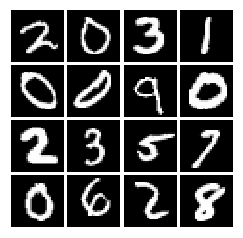

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./datasets/MNIST_data', one_hot=True) # include one-hot labels

# show a batch
next_batch = mnist.train.next_batch(16)
show_images(next_batch[0])
print (next_batch[1]) # labels

## LeakyReLU

In [3]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    act = tf.maximum(alpha * x, x)

    act = tf.cast(act, tf.float32)
    return act


## Random Noise

In [4]:
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # sample and return noise
    return tf.random_uniform((batch_size, dim), -1, 1, dtype=tf.float32)


## Downsample Image

In [5]:
def downsampled_img(batch_size, img, K):
    """Downsample image
    
    Inputs:
    - batch_size: integer giving the batch size
    - img: input image
    
    Returns:
    TensorFlow Tensor of downsized img
    """
    IMAGE_SIZE = 28
    img = tf.reshape(img, (batch_size, IMAGE_SIZE, IMAGE_SIZE, 1))
    x_small = tf.image.resize_bicubic(img, (int(IMAGE_SIZE/K), int(IMAGE_SIZE/K)))
    x_small = tf.reshape(x_small, (batch_size, -1))
    return x_small

## Conditional Discriminator/Generator

In [6]:
def discriminator(x, y):
    """Compute discriminator score for a batch of input images.

    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]

    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        inputs = tf.concat(values=[x, y], axis=1)

        fc1 = tf.layers.dense(inputs=inputs, units=256, activation=leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc2, units=1, activation=None)
        return logits

def generator(z, y):
    """Generate images from a random noise vector.

    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]

    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        inputs = tf.concat(values=[z, y], axis=1)

        fc1 = tf.layers.dense(inputs=inputs, units=1024, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu)
        img = tf.layers.dense(inputs=fc2, units=784, activation=tf.nn.tanh)
        return img

# GAN Loss

In [7]:
def gan_loss(logits_real, logits_fake, generator_output, original_image, original_image_downscaled, batch_size):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    alpha = 0.9 # higher: weight more towards using content loss 
    
    # compute D_loss and G_loss
    D_loss = -tf.reduce_mean(tf.log(tf.nn.sigmoid(logits_real)), 0) - tf.reduce_mean(tf.log(1.0 - tf.nn.sigmoid(logits_fake)), 0)
    G_loss = -tf.reduce_mean(tf.log(tf.nn.sigmoid(logits_fake)), 0)
    
#     downscaled_gen_output = downsampled_img(batch_size, generator_output, 4)
    generator_l1_loss  = tf.reduce_mean(tf.abs(generator_output - original_image), name='gene_l1_loss')
    G_loss = tf.add((1.0 - alpha) * G_loss, alpha * generator_l1_loss)
    D_loss = tf.cast(D_loss, tf.float32)[0]
    G_loss = tf.cast(G_loss, tf.float32)[0]
    return D_loss, G_loss

# Optimizing our loss

In [8]:
# create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate, beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate, beta1)

    return D_solver, G_solver

## Putting it all together

In [9]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 100
# number of labels
num_labels = mnist.train.labels.shape[1]

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
y = tf.placeholder(tf.float32, shape=[None, num_labels])

# random noise fed into our generator
z = downsampled_img(batch_size, x, 4)
# z = sample_noise(batch_size, noise_dim)
z = tf.cast(z, tf.float32)

# generated images
G_sample = generator(z, y)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x), y)
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample, y)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake, G_sample, x, z, batch_size)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# Get Test Files
To share across CGAN and Vanilla-GAN

In [10]:
testbatch,testbatch_y = mnist.test.next_batch(batch_size)

# Training a CGAN

In [11]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    num_samples = 16

    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        minibatch,minibatch_y = mnist.train.next_batch(batch_size)
        if it % show_every == 0:
            
            downsampled = sess.run(z, feed_dict={x: minibatch})
            samples = sess.run(G_sample, feed_dict={x: minibatch, y:minibatch_y})
            
            original_fig = show_images(minibatch[:num_samples])
            plt.show()
            downsampled_fig = show_images(downsampled[:num_samples])
            plt.show()
            fig = show_images(samples[:num_samples])
            plt.show()
            
            print()
        # run a batch of data through the network
        
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch, y:minibatch_y})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch, y:minibatch_y})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
    print('Final images')
    downsampled = sess.run(z, feed_dict={x: testbatch, y:testbatch_y})
    samples = sess.run(G_sample, feed_dict={x: testbatch, y:testbatch_y})

    original_fig = show_images(testbatch[:num_samples])
    plt.show()
    downsampled_fig = show_images(downsampled[:num_samples])
    plt.show()
    fig = show_images(samples[:num_samples])
    plt.show()
            

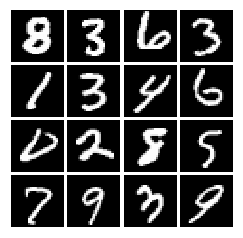

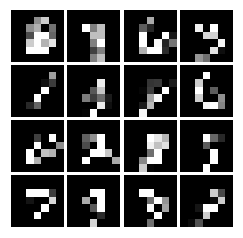

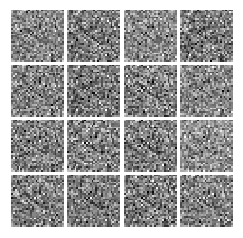


Iter: 0, D: 2.135, G:0.218
Iter: 50, D: 0.6435, G:0.2595
Iter: 100, D: 0.4024, G:0.3511
Iter: 150, D: 0.8847, G:0.4387
Iter: 200, D: 0.4517, G:0.5338


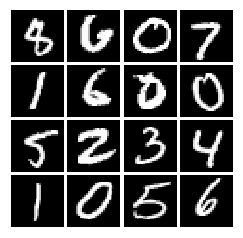

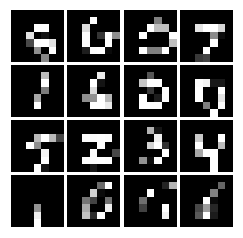

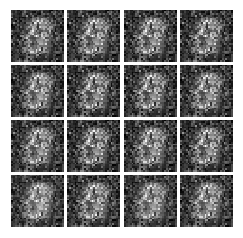


Iter: 250, D: 0.7513, G:0.7747
Iter: 300, D: 0.3005, G:0.7339
Iter: 350, D: 0.2771, G:0.8699
Iter: 400, D: 0.9847, G:0.9085
Iter: 450, D: 0.3631, G:0.8513


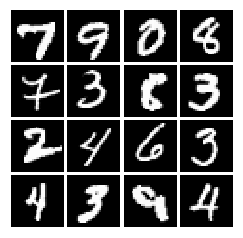

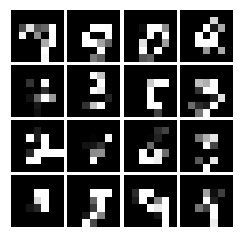

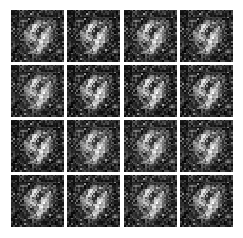


Iter: 500, D: 0.4043, G:0.7214
Iter: 550, D: 0.4194, G:0.8232
Iter: 600, D: 0.7553, G:0.8651
Iter: 650, D: 0.4083, G:0.8937
Iter: 700, D: 0.771, G:0.7617


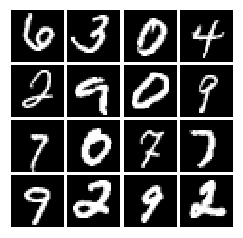

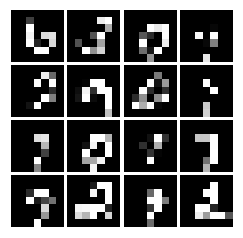

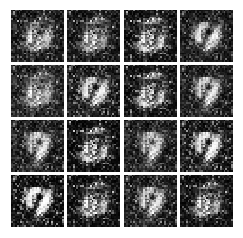


Iter: 750, D: 0.6763, G:0.7835
Iter: 800, D: 0.5731, G:0.7602
Iter: 850, D: 0.7249, G:1.115
Iter: 900, D: 1.083, G:0.8049
Iter: 950, D: 0.8892, G:0.818


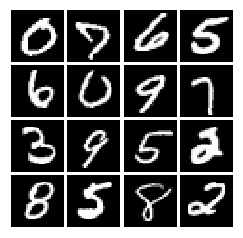

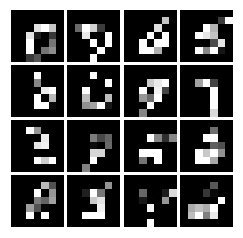

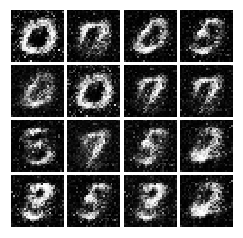


Iter: 1000, D: 1.168, G:0.8366
Iter: 1050, D: 1.027, G:0.9966
Iter: 1100, D: 0.8906, G:0.8297
Iter: 1150, D: 0.8849, G:0.8696
Iter: 1200, D: 0.9359, G:0.8738


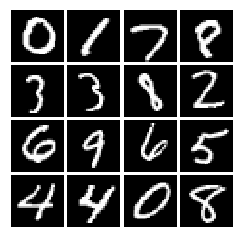

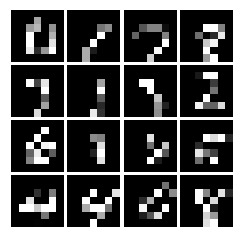

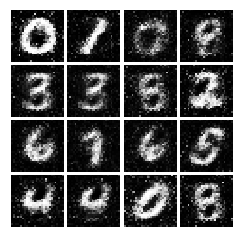


Iter: 1250, D: 1.062, G:0.8386
Iter: 1300, D: 1.041, G:0.8894
Iter: 1350, D: 0.9853, G:0.8482
Iter: 1400, D: 1.045, G:0.8097
Iter: 1450, D: 0.9283, G:0.849


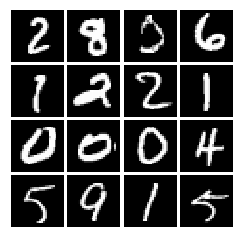

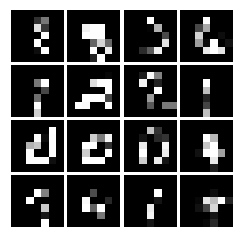

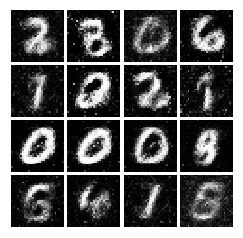


Iter: 1500, D: 1.003, G:0.8936
Iter: 1550, D: 0.974, G:0.8704
Iter: 1600, D: 1.273, G:0.8766
Iter: 1650, D: 1.154, G:0.8523
Iter: 1700, D: 1.153, G:0.8266


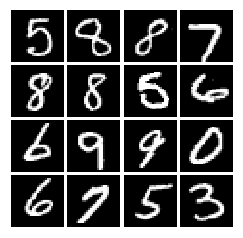

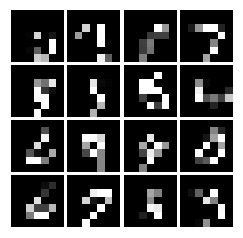

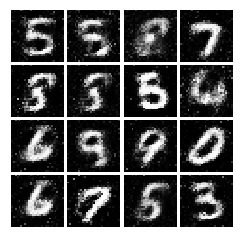


Iter: 1750, D: 1.119, G:0.8294
Iter: 1800, D: 1.219, G:0.8478
Iter: 1850, D: 1.126, G:0.8491
Iter: 1900, D: 1.153, G:0.8497
Iter: 1950, D: 1.123, G:0.8732


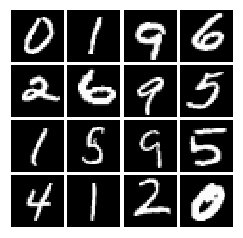

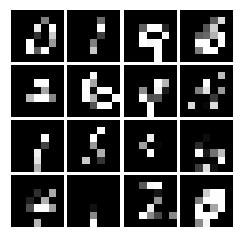

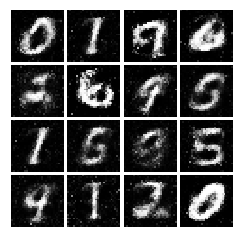


Iter: 2000, D: 1.139, G:0.8878
Iter: 2050, D: 1.085, G:0.8818
Iter: 2100, D: 1.2, G:0.8552
Iter: 2150, D: 1.182, G:0.878
Iter: 2200, D: 1.115, G:0.8498


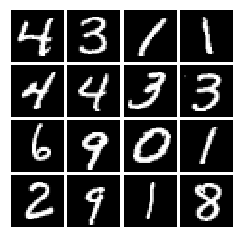

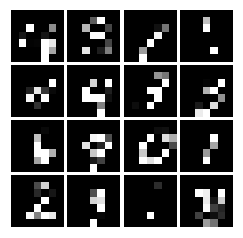

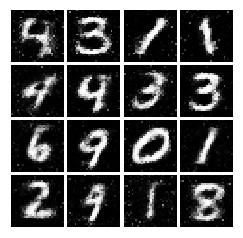


Iter: 2250, D: 1.092, G:0.8625
Iter: 2300, D: 1.125, G:0.8708
Iter: 2350, D: 1.133, G:0.8643
Iter: 2400, D: 1.15, G:0.8326
Iter: 2450, D: 1.161, G:0.8433


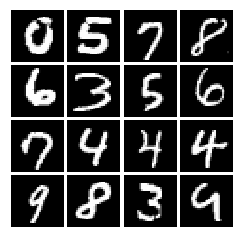

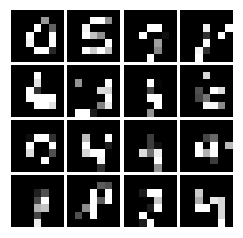

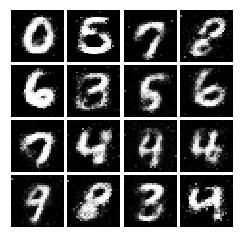


Iter: 2500, D: 1.077, G:0.8617
Iter: 2550, D: 1.167, G:0.8839
Iter: 2600, D: 1.156, G:0.8352
Iter: 2650, D: 1.165, G:0.8861
Iter: 2700, D: 1.275, G:0.8758


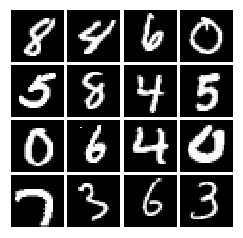

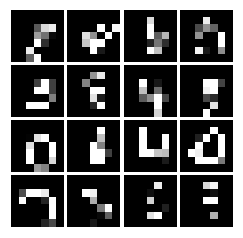

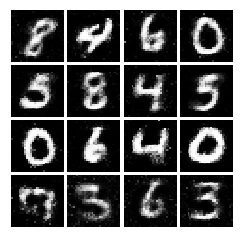


Iter: 2750, D: 1.175, G:0.8743
Iter: 2800, D: 1.172, G:0.8586
Iter: 2850, D: 1.135, G:0.8435
Iter: 2900, D: 1.151, G:0.8621
Iter: 2950, D: 1.106, G:0.8752


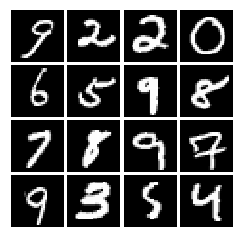

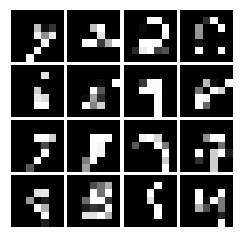

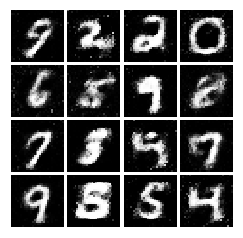


Iter: 3000, D: 1.14, G:0.8359
Iter: 3050, D: 1.198, G:0.8931
Iter: 3100, D: 1.164, G:0.8753
Iter: 3150, D: 1.191, G:0.8642
Iter: 3200, D: 1.082, G:0.8545


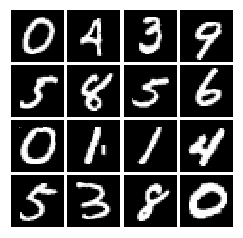

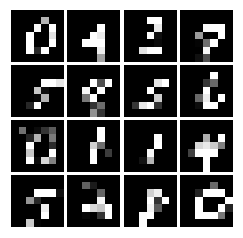

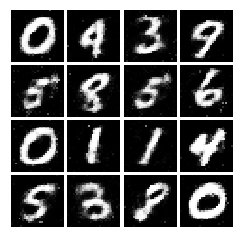


Iter: 3250, D: 1.129, G:0.851
Iter: 3300, D: 1.256, G:0.8498
Iter: 3350, D: 1.184, G:0.8541
Iter: 3400, D: 1.179, G:0.8719
Iter: 3450, D: 1.256, G:0.8535


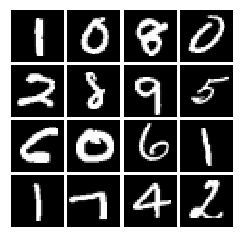

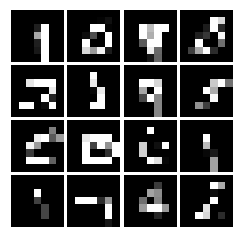

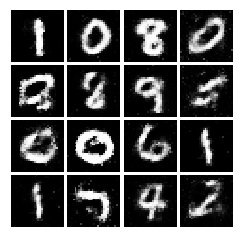


Iter: 3500, D: 1.23, G:0.8819
Iter: 3550, D: 1.139, G:0.899
Iter: 3600, D: 1.178, G:0.8525
Iter: 3650, D: 1.064, G:0.8522
Iter: 3700, D: 1.203, G:0.8455


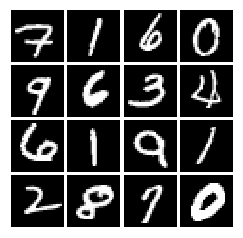

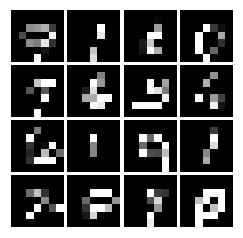

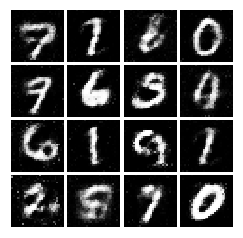


Iter: 3750, D: 1.286, G:0.859
Iter: 3800, D: 1.227, G:0.9255
Iter: 3850, D: 1.269, G:0.9062
Iter: 3900, D: 1.141, G:0.8585
Iter: 3950, D: 1.192, G:0.8804


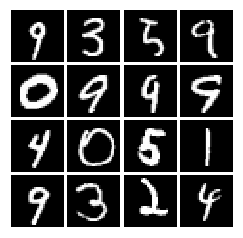

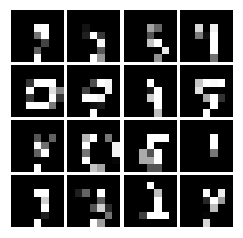

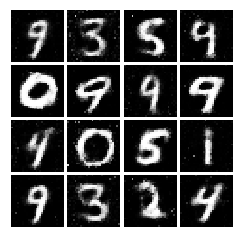


Iter: 4000, D: 1.191, G:0.8533
Iter: 4050, D: 1.203, G:0.8872
Iter: 4100, D: 1.314, G:0.9083
Iter: 4150, D: 1.218, G:0.873
Iter: 4200, D: 1.157, G:0.8954


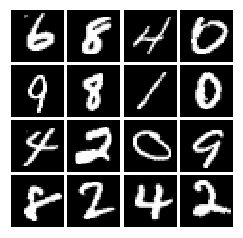

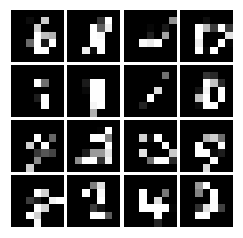

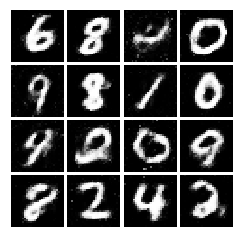


Iter: 4250, D: 1.219, G:0.872
Final images


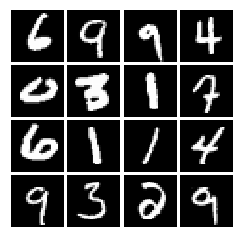

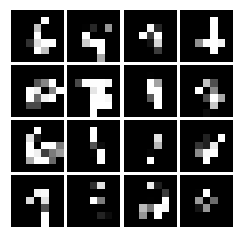

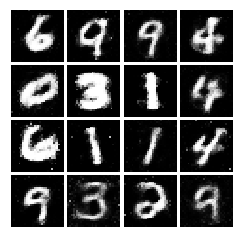

In [12]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

# Training a Vanilla GAN

In [13]:
def vanilla_discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("vanilla_discriminator"):
        fc1 = tf.layers.dense(inputs=x, units=256, activation=leaky_relu)
        fc2 = tf.layers.dense(inputs=fc1, units=256, activation=leaky_relu)
        logits = tf.layers.dense(inputs=fc2, units=1)
       
        logits = tf.cast(logits, tf.float32)

        return logits

def vanilla_generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("vanilla_generator"):
        # implement architecture
        fc1 = tf.layers.dense(inputs=z, units=1024, activation=tf.nn.relu)
        fc2 = tf.layers.dense(inputs=fc1, units=1024, activation=tf.nn.relu)
        fc3 = tf.layers.dense(inputs=fc2, units=784)
        img = tf.tanh(fc3)
        img = tf.cast(img, tf.float32)
        return img

In [14]:
# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    num_samples = 16
    
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        if it % show_every == 0:
            downsampled = sess.run(z, feed_dict={x: minibatch})
            samples = sess.run(G_sample, feed_dict={x: minibatch})
            
            original_fig = show_images(minibatch[:num_samples])
            plt.show()
            downsampled_fig = show_images(downsampled[:num_samples])
            plt.show()
            fig = show_images(samples[:num_samples])
            plt.show()
            
            print()
        # run a batch of data through the network
        
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={x: minibatch})

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
            
    print('Final images')    
    downsampled = sess.run(z, feed_dict={x: testbatch})
    samples = sess.run(G_sample, feed_dict={x: testbatch})

    original_fig = show_images(testbatch[:num_samples])
    plt.show()
    downsampled_fig = show_images(downsampled[:num_samples])
    plt.show()
    fig = show_images(samples[:num_samples])
    plt.show()

In [15]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 100

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])

# random noise fed into our generator
z = downsampled_img(batch_size, x, 4)
# z = sample_noise(batch_size, noise_dim)
z = tf.cast(z, tf.float32)

# generated images
G_sample = vanilla_generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = vanilla_discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = vanilla_discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla_discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla_generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake, G_sample, x, z, batch_size)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'vanilla_discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'vanilla_generator')

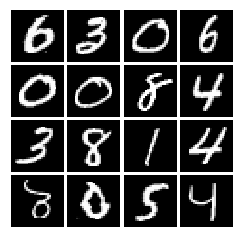

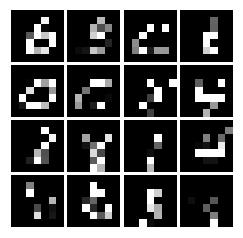

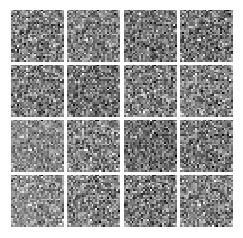


Iter: 0, D: 1.241, G:0.2114
Iter: 50, D: 2.323, G:0.4528
Iter: 100, D: 0.2128, G:0.3972
Iter: 150, D: 0.4094, G:0.4148
Iter: 200, D: 3.114, G:0.2865


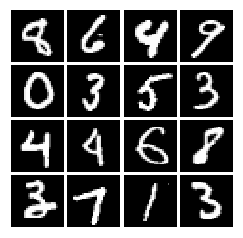

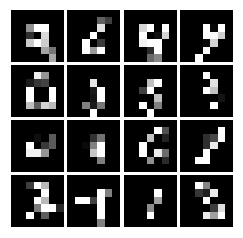

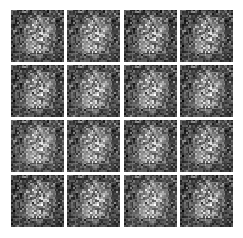


Iter: 250, D: 0.6219, G:0.5887
Iter: 300, D: 0.3604, G:0.4566
Iter: 350, D: 0.3327, G:0.5876
Iter: 400, D: 0.4868, G:0.8112
Iter: 450, D: 0.3864, G:0.7418


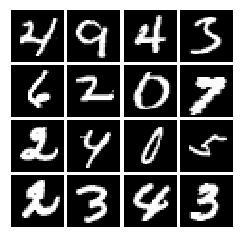

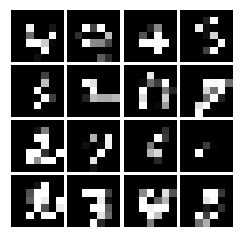

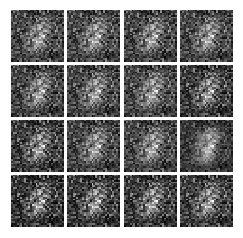


Iter: 500, D: 0.2006, G:0.8254
Iter: 550, D: 0.4294, G:0.6474
Iter: 600, D: 0.4445, G:0.7684
Iter: 650, D: 0.3821, G:0.6449
Iter: 700, D: 0.4224, G:0.9207


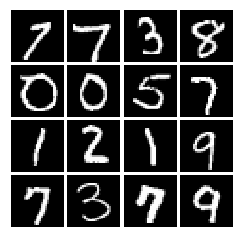

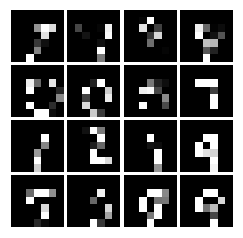

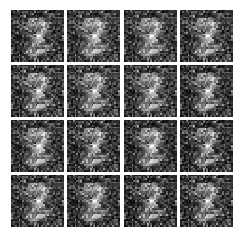


Iter: 750, D: 0.1864, G:0.8531
Iter: 800, D: 0.6226, G:0.864
Iter: 850, D: 0.3359, G:0.8138
Iter: 900, D: 0.3348, G:0.8126
Iter: 950, D: 0.3894, G:0.7845


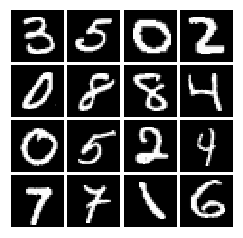

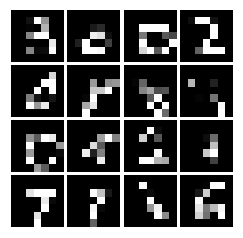

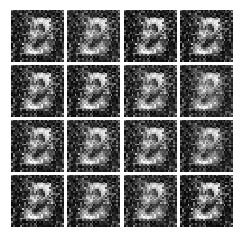


Iter: 1000, D: 0.4295, G:0.822
Iter: 1050, D: 0.9879, G:0.9182
Iter: 1100, D: 0.9875, G:0.9128
Iter: 1150, D: 0.8164, G:0.9358
Iter: 1200, D: 0.7406, G:0.9499


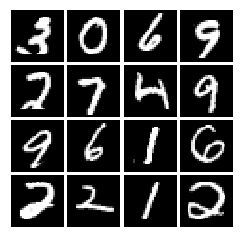

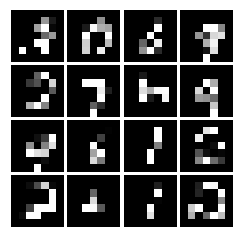

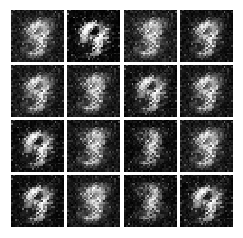


Iter: 1250, D: 0.4835, G:0.9055
Iter: 1300, D: 0.7446, G:0.8792
Iter: 1350, D: 1.581, G:0.8688
Iter: 1400, D: 0.7659, G:0.9238
Iter: 1450, D: 0.9344, G:0.9019


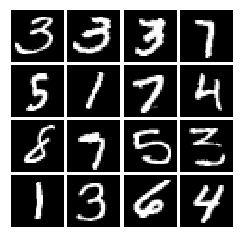

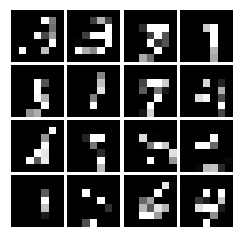

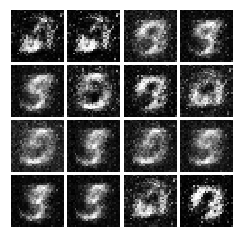


Iter: 1500, D: 0.694, G:0.8526
Iter: 1550, D: 1.001, G:0.8964
Iter: 1600, D: 0.9349, G:0.914
Iter: 1650, D: 1.063, G:0.8791
Iter: 1700, D: 0.9554, G:0.8634


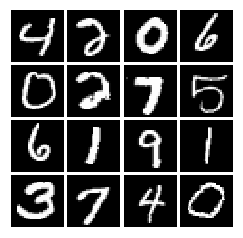

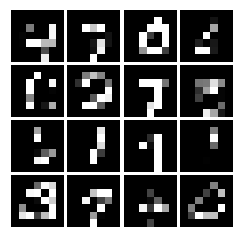

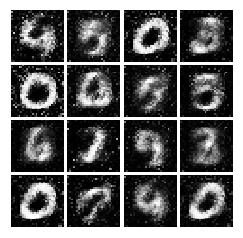


Iter: 1750, D: 0.9091, G:0.8282
Iter: 1800, D: 1.12, G:0.8433
Iter: 1850, D: 1.105, G:0.8366
Iter: 1900, D: 0.9697, G:0.8528
Iter: 1950, D: 1.347, G:0.8746


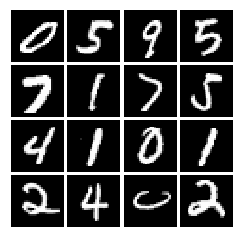

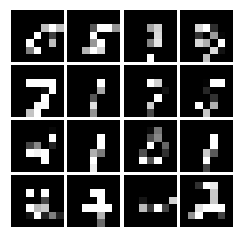

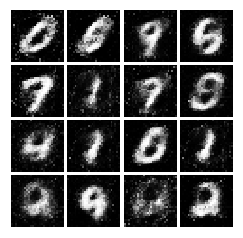


Iter: 2000, D: 1.093, G:0.8599
Iter: 2050, D: 0.9179, G:0.8448
Iter: 2100, D: 1.122, G:0.847
Iter: 2150, D: 1.185, G:0.8583
Iter: 2200, D: 1.246, G:0.8616


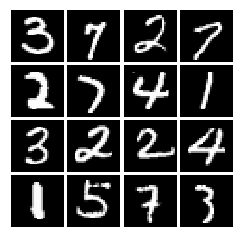

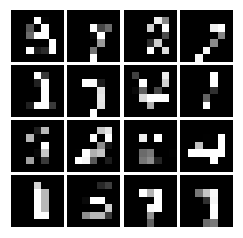

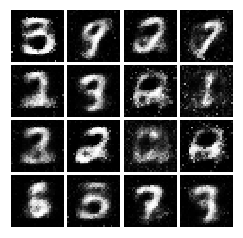


Iter: 2250, D: 1.085, G:0.8675
Iter: 2300, D: 1.07, G:0.8644
Iter: 2350, D: 1.099, G:0.8899
Iter: 2400, D: 1.127, G:0.8293
Iter: 2450, D: 1.124, G:0.8774


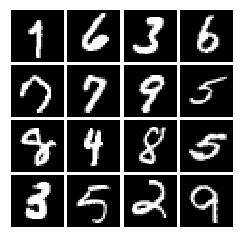

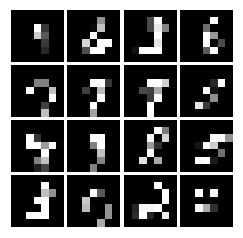

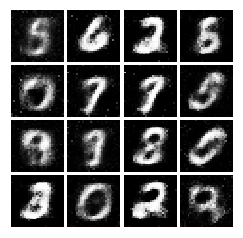


Iter: 2500, D: 1.03, G:0.8581
Iter: 2550, D: 1.21, G:0.8761
Iter: 2600, D: 1.073, G:0.8384
Iter: 2650, D: 1.084, G:0.8543
Iter: 2700, D: 1.186, G:0.8404


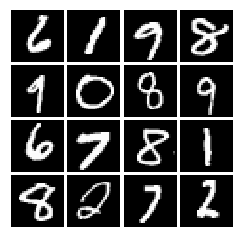

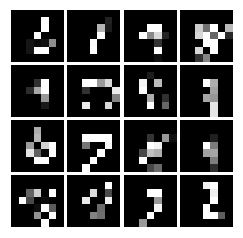

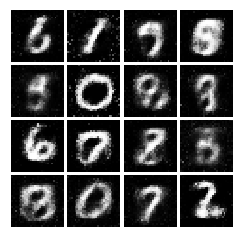


Iter: 2750, D: 1.127, G:0.849
Iter: 2800, D: 1.254, G:0.8703
Iter: 2850, D: 1.117, G:0.8888
Iter: 2900, D: 1.115, G:0.8475
Iter: 2950, D: 1.243, G:0.8792


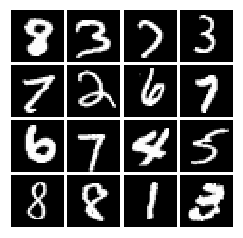

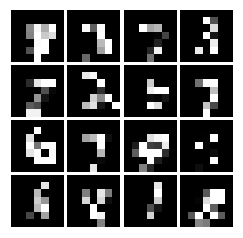

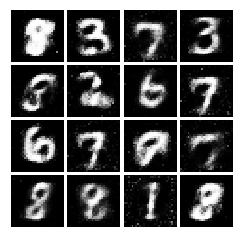


Iter: 3000, D: 1.277, G:0.8682
Iter: 3050, D: 1.282, G:0.8512
Iter: 3100, D: 1.098, G:0.8483
Iter: 3150, D: 1.18, G:0.8629
Iter: 3200, D: 1.208, G:0.8852


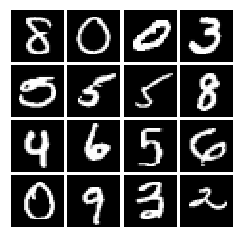

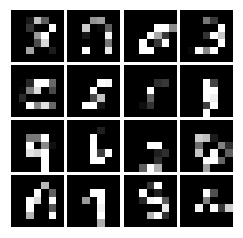

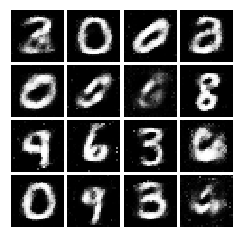


Iter: 3250, D: 1.177, G:0.8844
Iter: 3300, D: 1.128, G:0.878
Iter: 3350, D: 1.153, G:0.8575
Iter: 3400, D: 1.173, G:0.8546
Iter: 3450, D: 1.419, G:0.8962


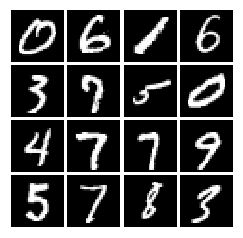

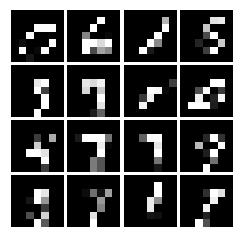

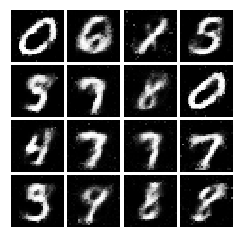


Iter: 3500, D: 1.208, G:0.8485
Iter: 3550, D: 1.077, G:0.8596
Iter: 3600, D: 1.266, G:0.8778
Iter: 3650, D: 1.085, G:0.8791
Iter: 3700, D: 1.291, G:0.8648


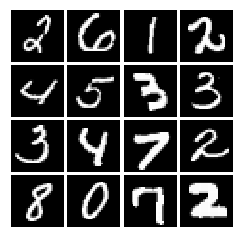

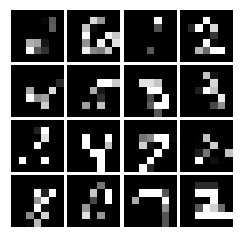

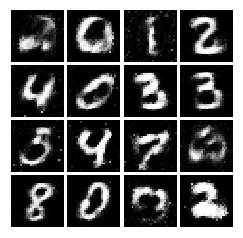


Iter: 3750, D: 1.28, G:0.8448
Iter: 3800, D: 1.485, G:0.8973
Iter: 3850, D: 1.204, G:0.8601
Iter: 3900, D: 1.18, G:0.8756
Iter: 3950, D: 1.201, G:0.8751


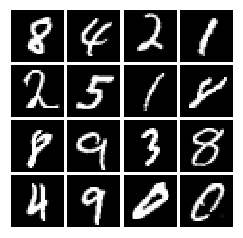

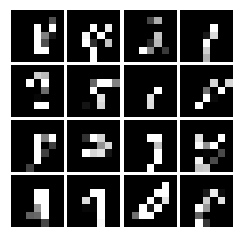

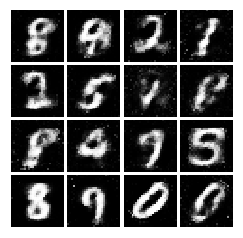


Iter: 4000, D: 1.118, G:0.8821
Iter: 4050, D: 1.3, G:0.8479
Iter: 4100, D: 1.228, G:0.8826
Iter: 4150, D: 1.144, G:0.8745
Iter: 4200, D: 1.226, G:0.851


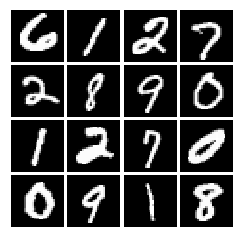

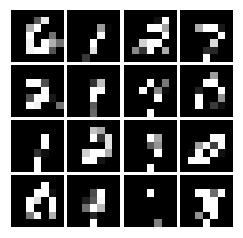

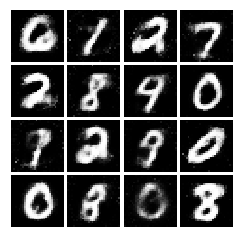


Iter: 4250, D: 1.154, G:0.8675
Final images


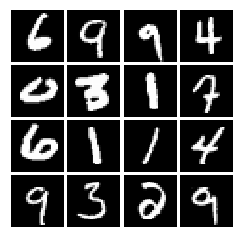

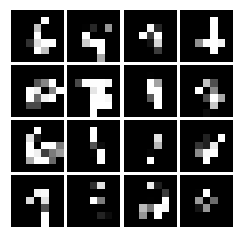

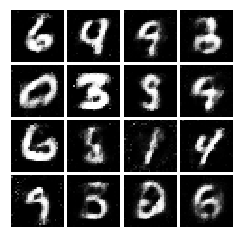

In [16]:
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)